## Util Functions and Library Imports

In [8]:
import random
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import math
import numpy as np
import time
from scipy.stats import logistic

test_result = {}
def read_json(file_name):
    with open(file_name, "r") as file:
        obj = json.load(file)
    return obj

## Creation of drone objects
#### Python function to simulate and save a scalable static scenario of drone data

In [9]:
def create_cds(n_drones):
    drones = []
    for i in range(n_drones):
        tier = random.choice([1, 2, 3, 4])
        energy = random.normalvariate(20, 2.5)
        packet_rate = random.normalvariate(200, 50)
        location = (random.uniform(-2000, 2000), random.uniform(-2000, 2000))
        drone = {
            "id": i + 1,
            "tier": tier,
            "energy": energy,
            "packet_rate": packet_rate,
            "location": location,
        }
        drones.append(drone)

    file_name = f"drone_sim_{n_drones}.json"
    with open(file_name, "w") as file:
        json.dump(drones, file, indent=2)

    print(f"Data for {n_drones} drones created and saved to {file_name}.")


## Configuring Controller State

Configure the standards of SLA for ZT grades, criticalities of drone tiers, enemy territory, respective ZT metric ranges for grades, and simulated CPU availability

In [10]:
controller_config = {
    "grade_network_sla": {
        'A': 1200,
        'B': 1000,
        'C': 800,
        'D': 600,
        'E': 400
    },
    "tier_criticality": {
        1: 1.5,
        2: 1.25,
        3: 1,
        4: 0.8
    },
    "enemy_center" : [-900, 200],
    "enemy_radius": 400,
    "available_cpu_cycles_billion": 3,
    "zt_score_grade": {
        'A': [80, 150],
        'B': [50, 80],
        'C': [30, 50],
        'D': [15, 30],
        'E': [0, 15]
    },
    "cooldown_period": 60
}
with open('controller_config.json', "w") as file:
    json.dump(controller_config, file, indent=2)


## Simulation of attack history

Defining a conditional proportionality function for attack outcome distribution

In [11]:
def conditional_distribution(delta, threshold):
    if delta <= threshold:
        # Linear increase up to 0.5 until the threshold
        slope = 0.5 / threshold
        return slope * delta
    else:
        # Faster exponential increase beyond the threshold
        k = 2.0  # Adjust the rate of exponential increase as needed
        return 0.5 + 0.5 * (1 - 2 ** (-k * (delta - threshold)))

def calculate_rayleigh_cdf(mu, x):
    sigma = mu / np.sqrt(np.pi / 2)
    cdf_value = 1 - np.exp(-x**2 / (2 * sigma**2))
    return cdf_value

Function to generate simulation data for attack history

In [13]:
def generate_attack_data(n):
    data = []

    # capture_x = np.linspace(0, 5000, 5000)
    # capture_truth_dist = logistic.cdf(capture_x, loc=1200, scale=500)
    # flooder_x = np.linspace(0, 30, 30)
    # flooder_truth_dist = logistic.cdf(flooder_x, loc=6, scale=2)
    # faker_x = np.linspace(0, 300, 500)
    # faker_truth_dist = logistic.cdf(faker_x, loc=80, scale=20)
    distance_deltas, packet_rate_deltas, energy_deltas = [], [], []
    for _ in range(n):
        distance_deltas.append(random.randint(0, 5000))
        packet_rate_deltas.append(random.randint(0, 200))
        energy_deltas.append(random.randint(0, 20))

    distance_delta_mean = sum(distance_deltas)/len(distance_deltas)
    pr_delta_mean = sum(packet_rate_deltas)/len(packet_rate_deltas)
    energy_delta_mean = sum(energy_deltas)/len(energy_deltas)

    for i in range(n):

        capture_truth_prob = calculate_rayleigh_cdf(distance_delta_mean, distance_deltas[i])
        # capture_truth_prob = capture_truth_dist[np.argmin(np.abs(capture_x - distance_delta))]
        is_capture = random.choices([True, False], weights=[capture_truth_prob, 1-capture_truth_prob])[0]

        flooder_truth_prob = calculate_rayleigh_cdf(pr_delta_mean, packet_rate_deltas[i])
        # flooder_truth_prob = flooder_truth_dist[np.argmin(np.abs(flooder_x - packet_rate_delta))]
        is_flooder_attack = random.choices([True, False], weights=[flooder_truth_prob, 1-flooder_truth_prob])[0]

        faker_truth_prob = calculate_rayleigh_cdf(energy_delta_mean, energy_deltas[i])
        # faker_truth_prob = faker_truth_dist[np.argmin(np.abs(faker_x - energy_delta))]
        is_faker_attack = random.choices([True, False], weights=[faker_truth_prob, 1-faker_truth_prob])[0]

        true_count = [is_faker_attack, is_flooder_attack, is_capture].count(True)
        if true_count == 3:
            attack_success = True
        elif true_count == 0:
            attack_success = False
        else:
            attack_success = random.choices([True, False], weights=[8/10, 2/10])[0]
        
        attack_info = {
            "distance_delta": distance_deltas[i],
            "packet_rate_delta": packet_rate_deltas[i],
            "energy_delta": energy_deltas[i],
            "is_capture": is_capture,
            "is_flooder_attack": is_flooder_attack,
            "is_faker_attack": is_faker_attack,
            "attack_success": attack_success
        }

        data.append(attack_info)

    df = pd.DataFrame(data)
    file_name = f"attack_sim_data_{n}.csv"
    df.to_csv(file_name, index=False)

    print(f"{n} rows of attack data generated and saved to {file_name}.")

In [14]:
a = [1, 2, 3]
print(sum(a)/len(a))

2.0


## Function to check proximity to enemy base and report danger

In [15]:
def eucliden_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def is_in_enemy_territory(my_location, enemy_center, enemy_radius):
    distance_to_enemy_center = eucliden_distance(enemy_center, my_location)

    return distance_to_enemy_center <= enemy_radius

## Bayesian Network Model to calculate Risk

In [16]:
def get_bn_risk(attack_data, cds_data, request, enemy_center, enemy_radius):
    
    global test_result
    energy_values = [drone["energy"] for drone in cds_data if drone["id"] != request['sourceDroneId']]
    average_energy = sum(energy_values) / len(energy_values)
    energy_delta = request['energy'] - average_energy if request['energy'] > average_energy else 0
    print(f'averageenergy: {average_energy}, energy_delta: {energy_delta}')
    fakerCPT = {}
    numerator = len(attack_data.query(f'(energy_delta >= {energy_delta - 3}) & (energy_delta <= {energy_delta + 3}) & (is_faker_attack == True)'))
    denominator = len(attack_data.query(f'(energy_delta >= {energy_delta - 3}) & (energy_delta <= {energy_delta + 3})'))
    if energy_delta > attack_data['energy_delta'].max():
        fakerCPT[True] = 0.99    
    elif energy_delta == 0 or numerator == 0:
        fakerCPT[True] = 0.01
    elif numerator/denominator == 1:
        fakerCPT[True] = 0.99    
    else:
        fakerCPT[True] = numerator / denominator
    fakerCPT[False] = 1 - fakerCPT[True]
    print(f'Faker prob: {fakerCPT[True]}')

    packet_rate_values = [drone["packet_rate"] for drone in cds_data if drone["id"] != request['sourceDroneId']]
    average_packet_rate = sum(packet_rate_values) / len(packet_rate_values)
    print(f'averagePacketRate: {average_packet_rate}')
    packet_rate_delta = request['packetRate'] - average_packet_rate if request['packetRate'] > average_packet_rate else 0
    print(f'packetRateDelta: {packet_rate_delta}')
    flooderCPT = {}
    numerator = len(attack_data.query(f'(packet_rate_delta >= {packet_rate_delta - 15}) & (packet_rate_delta <= {packet_rate_delta + 15}) & (is_flooder_attack == True)'))
    denominator = len(attack_data.query(f'(packet_rate_delta >= {packet_rate_delta - 15}) & (packet_rate_delta <= {packet_rate_delta + 15})'))
    if packet_rate_delta > attack_data['packet_rate_delta'].max():
        flooderCPT[True] = 0.99  
    elif packet_rate_delta == 0 or denominator == 0 or numerator == 0:
        flooderCPT[True] = 0.01
    elif numerator/denominator == 1:
        flooderCPT[True] = 0.99    
    else:
        flooderCPT[True] = numerator / denominator
    flooderCPT[False] = 1 - flooderCPT[True]
    print(f'Flooder prob: {flooderCPT[True]}')

    captureCPT = {}
    if is_in_enemy_territory(request['location'], enemy_center, enemy_radius):
        captureCPT[True] = 0.99
        distance, average_distance, distance_delta = 100, 100, 100
    else:
        distance_values = [eucliden_distance(drone["location"], (0, 0)) for drone in cds_data if drone["id"] != request['sourceDroneId']]
        average_distance = sum(distance_values) / len(distance_values)
        distance = eucliden_distance(request['location'], (0, 0))
        distance_delta = distance - average_distance if distance > average_distance else 0
        numerator =  len(attack_data.query(f'(distance_delta >= {distance_delta - 200}) & (distance_delta <= {distance_delta + 200}) & (is_capture == True)'))
        denominator = len(attack_data.query(f'(distance_delta >= {distance_delta - 200}) & (distance_delta <= {distance_delta + 200})'))
        print(f'distAvg: {average_distance}, distDelta: {distance_delta}')
        if distance_delta > attack_data['distance_delta'].max():
            captureCPT[True] = 0.99  
        elif distance_delta == 0 or denominator == 0 or numerator == 0:
            captureCPT[True] = 0.01
        elif numerator/denominator == 1:
            captureCPT[True] = 0.99    
        else:
            captureCPT[True] = numerator / denominator
    captureCPT[False] = 1 - captureCPT[True]
    print(f'capture prob: {captureCPT[True]}')

    risk = 0
    for perm in [list(p) for p in product([True, False], repeat=3)]:
        numerator = len(attack_data.query(f'(is_capture == {perm[2]}) & (is_flooder_attack == {perm[0]}) & (is_faker_attack == {perm[1]}) & (attack_success == True)'))
        denominator = len(attack_data.query(f'(is_capture == {perm[2]}) & (is_flooder_attack == {perm[0]}) & (is_faker_attack == {perm[1]})'))
        if denominator == 0:
            cond_prob = 0.01
        elif numerator == denominator:
            cond_prob = 0.99
        else:
            cond_prob = numerator / denominator
        
        risk += cond_prob * flooderCPT[perm[0]] * fakerCPT[perm[1]] * captureCPT[perm[2]]
    
    test_result_keys = ['srcDroneId', 'destDroneId', 'packetRate', 'energy', 'distance', 'packetRateAvg', 'energyAvg', 'distanceAvg', 'packetRateDelta', 'energyDelta', 'distanceDelta', 'flooderProb', 'fakerProb', 'captureProb', 'riskScore' ]
    test_result_values = [request['sourceDroneId'], request['destDroneId'], request['packetRate'], request['energy'], distance, average_packet_rate, average_energy, average_distance, packet_rate_delta, energy_delta, distance_delta, flooderCPT[True], fakerCPT[True], captureCPT[True], risk]
    test_result.update({k: v for k, v in zip(test_result_keys, test_result_values)})
    return risk

## Risk-based Zero Trust Scale

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_compute_easer(cpu_cycles):
    # Define the range of x values for the sigmoid function
    x_min = 0
    x_max = 10
    
    # Calculate the x value from CPU cycles within the defined range
    x = (cpu_cycles - x_min) / (x_max - x_min)
    
    # Calculate the corresponding y-axis value using the sigmoid function
    y = sigmoid(x)
    
    # Return the multiplier value (y-axis value)
    return y

In [18]:
def execute_zerotrust(drone_sim_file, attack_data_file, controller_config_file, request):
    start_time = time.time()
    global test_result
    controller_config = read_json(controller_config_file)
    drone_sim_data = read_json(drone_sim_file)
    attack_data = pd.read_csv(attack_data_file)
    risk = get_bn_risk(attack_data, drone_sim_data, request, controller_config['enemy_center'], controller_config['enemy_radius'])
    print(drone_sim_data)
    record = next((item for item in drone_sim_data if item.get('id') == request['destDroneId']), None)
    criticality = controller_config['tier_criticality'][str(record['tier'])]
        # criticality = controller_config[drone_sim_data[request['destDroneId']]]
    compute_easer = 1 if criticality >= 1.25 else get_compute_easer(controller_config['available_cpu_cycles_billion'])

    zt_metric = risk * compute_easer * criticality * 100 # ZT Metric formulation
    print(f'ZT Metric = {zt_metric}')
    grade_zt_range_map = controller_config['zt_score_grade']
    zt_grade = 'A' # Just a string assignment
    for grade in grade_zt_range_map.keys():
        print(grade)
        print(grade_zt_range_map[grade][0], grade_zt_range_map[grade][1]+1)
        if grade_zt_range_map[grade][0] <= zt_metric and zt_metric <= grade_zt_range_map[grade][1]:
            print(f'It is true for {grade}')
            zt_grade = grade
            break
    sla = controller_config['grade_network_sla'][zt_grade]

    test_result_keys = ['criticality', 'destDroneTier', 'avlCpuCycles', 'computeEaser', 'slaNetworkSpeed', 'networkSpeed', 'ztMetric', 'initZtGrade']
    test_result_values = [criticality, record['tier'], controller_config['available_cpu_cycles_billion'], compute_easer, sla, request['networkSpeed'], zt_metric, zt_grade]
    test_result.update({k: v for k, v in zip(test_result_keys, test_result_values)})

    if request['networkSpeed'] >= sla:
        pass
    elif request['networkSpeed'] >= sla * 0.8:
        print(f'The requesting drone satisfies only 80%% of initial grade-{zt_grade} SLA requirements. Downgrading.')
        zt_grade = chr(ord(zt_grade) + 1)
    else:
        print(f"The requesting drone's network speed doesn't comply to the SLA requirement of ZT Grade-{zt_grade}. Executing a deny policy until cool-down time for {controller_config['cooldown_period']}.")
        test_result['finalZtGrade'] = 'deny until cooldown'
        print(f'Execution Time: {time.time() - start_time}')
        return
    test_result['finalZtGrade'] = zt_grade
    print(f'Executing Grade-{zt_grade} Zero Trust Security policies.')
    print(f'Execution Time: {time.time() - start_time}')


## Attack Simulation

For 16 drones and 100 records of attack data

In [19]:
create_cds(16)
generate_attack_data(100)

Data for 16 drones created and saved to drone_sim_16.json.
100 rows of attack data generated and saved to attack_sim_data_100.csv.


In [20]:
request = {
    "sourceDroneId": 4,
    "destDroneId": 6,
    "networkSpeed": 1000,
    "energy": 24,
    "packetRate": 243, 
    "location": [36, 45]
}

In [21]:
execute_zerotrust('drone_sim_16.json', 'attack_sim_data_100.csv', 'controller_config.json', request)

averageenergy: 19.728319876701846, energy_delta: 4.271680123298154
Faker prob: 0.21428571428571427
averagePacketRate: 203.16036291273937
packetRateDelta: 39.83963708726063
Flooder prob: 0.125
distAvg: 1342.5853295182217, distDelta: 0
capture prob: 0.01
[{'id': 1, 'tier': 2, 'energy': 18.789475707440243, 'packet_rate': 272.53453269673076, 'location': [103.21854065104117, -879.7942581961004]}, {'id': 2, 'tier': 3, 'energy': 20.073392206903247, 'packet_rate': 217.66594647829567, 'location': [649.2263704676652, 184.98035139894318]}, {'id': 3, 'tier': 3, 'energy': 20.18751673033683, 'packet_rate': 200.22632853175818, 'location': [1156.1689597455588, -1582.5439821427735]}, {'id': 4, 'tier': 3, 'energy': 22.279868089961766, 'packet_rate': 166.10736137944792, 'location': [-1013.7442137621364, -1270.1989114136247]}, {'id': 5, 'tier': 4, 'energy': 16.05362521891686, 'packet_rate': 169.88979040817054, 'location': [1583.136504899664, 626.0871514844293]}, {'id': 6, 'tier': 3, 'energy': 19.912947173

# Write to File

In [22]:
file_name = 'test_results.csv'
print(len(test_result))
try:
    # Try reading the existing file
    existing_data = pd.read_csv(file_name)
except FileNotFoundError:
    # If the file doesn't exist, create a new DataFrame
    existing_data = pd.DataFrame()

# Convert the new data dictionary to a DataFrame
new_data_df = pd.DataFrame([test_result])

# Append the new data to the existing DataFrame
updated_data = pd.concat([existing_data, new_data_df], ignore_index=True)

# Save the updated DataFrame to the CSV file
updated_data.to_csv(file_name, index=False)
print("Results saved to csv file.")

24
Results saved to csv file.


For 32 drones and 200 records of attack data

In [23]:
create_cds(32)
generate_attack_data(200)

Data for 32 drones created and saved to drone_sim_32.json.
200 rows of attack data generated and saved to attack_sim_data_200.csv.


In [24]:
request = {
    "sourceDroneId": 3,
    "destDroneId": 7,
    "networkSpeed": 600,
    "energy": 43,
    "packetRate": 340, 
    "location": [109, 200]
}

In [25]:
execute_zerotrust('drone_sim_32.json', 'attack_sim_data_200.csv', 'controller_config.json', request)

averageenergy: 20.113782050875827, energy_delta: 22.886217949124173
Faker prob: 0.99
averagePacketRate: 201.7528867988754
packetRateDelta: 138.2471132011246
Flooder prob: 0.8695652173913043
distAvg: 1418.8509758038967, distDelta: 0
capture prob: 0.01
[{'id': 1, 'tier': 4, 'energy': 21.504180049480368, 'packet_rate': 173.50243580314574, 'location': [-737.7716560116428, -1847.6644801488783]}, {'id': 2, 'tier': 4, 'energy': 17.991557154242813, 'packet_rate': 220.5147895166902, 'location': [-1759.487939772238, -1433.1058406056186]}, {'id': 3, 'tier': 1, 'energy': 21.10760677843116, 'packet_rate': 196.38106070345336, 'location': [1383.1905394745545, -306.10432049821543]}, {'id': 4, 'tier': 2, 'energy': 18.791414091784926, 'packet_rate': 118.82238402630493, 'location': [-378.02560411997, -661.268155021073]}, {'id': 5, 'tier': 1, 'energy': 18.804292281210834, 'packet_rate': 173.0398630751854, 'location': [543.0208007404376, -1706.6162318678662]}, {'id': 6, 'tier': 1, 'energy': 23.247203113841

For 160 drones and 1000 records of attack data

In [26]:
create_cds(160)
generate_attack_data(1000)

Data for 160 drones created and saved to drone_sim_160.json.
1000 rows of attack data generated and saved to attack_sim_data_1000.csv.


In [27]:
request = {
    "sourceDroneId": 3,
    "destDroneId": 7,
    "networkSpeed": 600,
    "energy": 28,
    "packetRate": 300, 
    "location": [35, 30]
}

In [28]:
execute_zerotrust('drone_sim_160.json', 'attack_sim_data_1000.csv', 'controller_config.json', request)

averageenergy: 19.72832924315688, energy_delta: 8.271670756843118
Faker prob: 0.429042904290429
averagePacketRate: 204.41299882587126
packetRateDelta: 95.58700117412874
Flooder prob: 0.5095541401273885
distAvg: 1468.0733735501456, distDelta: 0
capture prob: 0.01
[{'id': 1, 'tier': 1, 'energy': 21.365720085507668, 'packet_rate': 137.95087324422263, 'location': [878.5469257190302, 1341.4684767538556]}, {'id': 2, 'tier': 2, 'energy': 21.753817928249067, 'packet_rate': 187.2606230418638, 'location': [1859.9025585245759, 1514.0628975736058]}, {'id': 3, 'tier': 3, 'energy': 21.5619927362161, 'packet_rate': 221.13589744517247, 'location': [-1311.0897099192953, -886.1224787683302]}, {'id': 4, 'tier': 1, 'energy': 19.88592783614869, 'packet_rate': 210.76692203488767, 'location': [-1654.3271592035844, 996.0285735914495]}, {'id': 5, 'tier': 2, 'energy': 17.36749215239049, 'packet_rate': 122.29457417716122, 'location': [-488.57222909893903, -166.5169741798063]}, {'id': 6, 'tier': 3, 'energy': 18.4

For 1600 drones and 10000 records of attack data

In [29]:
create_cds(16000)
generate_attack_data(100000)

Data for 16000 drones created and saved to drone_sim_16000.json.
100000 rows of attack data generated and saved to attack_sim_data_100000.csv.


In [30]:
request = {
    "sourceDroneId": 3,
    "destDroneId": 7,
    "networkSpeed": 600,
    "energy": 28,
    "packetRate": 300, 
    "location": [35, 30]
}

In [31]:
execute_zerotrust('drone_sim_16000.json', 'attack_sim_data_100000.csv', 'controller_config.json', request)

averageenergy: 19.966925799195426, energy_delta: 8.033074200804574
Faker prob: 0.4348252777680418
averagePacketRate: 200.00412314056604
packetRateDelta: 99.99587685943396
Flooder prob: 0.5396804171959617
distAvg: 1528.414764501263, distDelta: 0
capture prob: 0.01
[{'id': 1, 'tier': 2, 'energy': 22.201978403867187, 'packet_rate': 151.6782389928514, 'location': [-828.0575977165579, -1204.3150750924747]}, {'id': 2, 'tier': 3, 'energy': 20.20888577751902, 'packet_rate': 243.16682914988834, 'location': [-1991.0605661523402, -360.73121771613523]}, {'id': 3, 'tier': 4, 'energy': 20.96036309037601, 'packet_rate': 117.09590329059213, 'location': [764.4154212696476, -1794.9167982325641]}, {'id': 4, 'tier': 4, 'energy': 20.222845047354166, 'packet_rate': 153.4120985750102, 'location': [-1209.6635905683613, -35.668372399703685]}, {'id': 5, 'tier': 2, 'energy': 17.321709464518342, 'packet_rate': 199.9210601056116, 'location': [120.79312514981257, -1111.5523932786919]}, {'id': 6, 'tier': 2, 'energy'

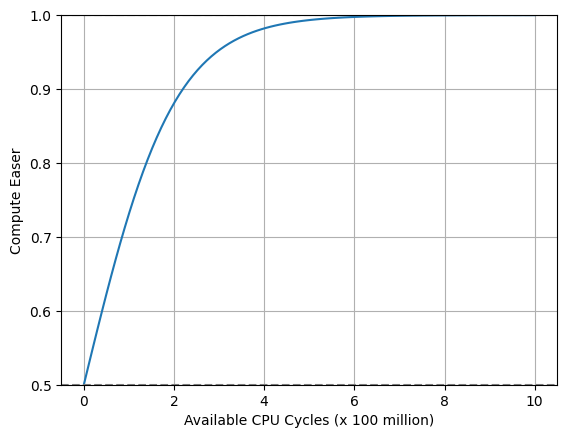

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.linspace(0, 10, 100)
y = sigmoid(x)

plt.plot(x, y)
plt.axhline(y=0.5, color='gray', linestyle='--')
plt.axhline(y=1, color='gray', linestyle='--')
plt.xlabel('Available CPU Cycles (x 100 million)')
plt.ylabel('Compute Easer')
plt.title('')
plt.grid(True)

# Set the y-limits to start at 0.5
plt.ylim(0.5, 1.0)

plt.show()

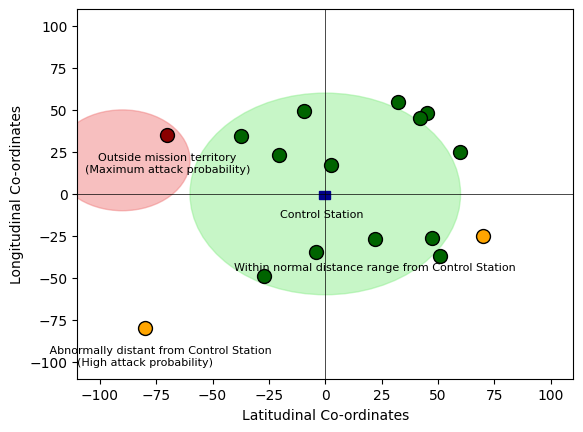

In [33]:
import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax = plt.subplots()

# Set axis limits
ax.set_xlim(-110, 110)
ax.set_ylim(-110, 110)

# Draw the transparent light green circle centered at the origin with radius 60
green_zone = plt.Circle((0, 0), 60, color='lightgreen', alpha=0.5)
ax.add_patch(green_zone)

# Draw the transparent light red circle at (-90, 20) with radius 30
circle = plt.Circle((-90, 20), 30, color='lightcoral', alpha=0.5)
ax.add_patch(circle)

# Draw the 16 thick points
points_data = [
    # Point in green zone
    {'x': 22, 'y': -27, 'color': 'darkgreen', 'label': 'Within normal distance range from Control Station'},

    # Point in uncolored zone
    {'x': -80, 'y': -80, 'color': 'orange', 'label': '         Abnormally distant from Control Station\n(High attack probability)'},

    # Point in the red zone (circular area)
    {'x': -70, 'y': 35, 'color': 'darkred', 'label': 'Outside mission territory\n(Maximum attack probability)'}
]

for point_data in points_data:
    ax.scatter(point_data['x'], point_data['y'], color=point_data['color'], s=100, zorder=10, edgecolors='black', linewidth=1)
    ax.annotate(point_data['label'], (point_data['x'], point_data['y']), fontsize=8, ha='center', va='center',
                textcoords="offset points", xytext=(0, -20), color='black', wrap=True)

# Set other points in the green zone
green_points = []
for _ in range(12):
    x = np.random.uniform(-60, 60)
    y = np.random.uniform(-60, 60)
    green_points.append({'x': x, 'y': y, 'color': 'darkgreen'})

for point_data in green_points:
    ax.scatter(point_data['x'], point_data['y'], color=point_data['color'], s=100, zorder=10, edgecolors='black', linewidth=1)

blip = plt.Rectangle((-3, -3), 5, 5, color='darkblue')
ax.add_patch(blip)
ax.text(-20, -15, 'Control Station', fontsize=8, ha='left', va='bottom', color='black')

# Set other points in the uncolored zone
uncolored_points = [
    {'x': 70, 'y': -25, 'color': 'orange'},
]

for point_data in uncolored_points:
    ax.scatter(point_data['x'], point_data['y'], color=point_data['color'], s=100, zorder=10, edgecolors='black', linewidth=1)

# Draw axes
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)

# Set axis labels
ax.set_xlabel('Latitudinal Co-ordinates')
ax.set_ylabel('Longitudinal Co-ordinates')

# Show the plot
plt.show()


## Simulation Automation for 100 requests

In [34]:
# Generate a list of dictionaries
data_list = []
file_name = 'test_results.csv'

for _ in range(100):
    req = {}
    req["sourceDroneId"] = np.random.choice(range(1, 33))
    req["destDroneId"] = np.random.choice(range(1, 33))
    req["networkSpeed"] = np.random.uniform(400, 1500)
    req["energy"] = np.random.uniform(0, 50)
    req["packetRate"] = np.random.uniform(180, 500)
    
    req["location"] = [np.random.uniform(-2500, 2500), np.random.uniform(-2500, 2500)]

    data_list.append(req)

# Print the generated list of dictionaries
for data_dict in data_list:
    print(data_dict)

for req in data_list:
    execute_zerotrust('drone_sim_32.json', 'attack_sim_data_200.csv', 'controller_config.json', req)
    print(len(test_result))
    try:
        # Try reading the existing file
        existing_data = pd.read_csv(file_name)
    except FileNotFoundError:
        # If the file doesn't exist, create a new DataFrame
        existing_data = pd.DataFrame()

    # Convert the new data dictionary to a DataFrame
    new_data_df = pd.DataFrame([test_result])

    # Append the new data to the existing DataFrame
    updated_data = pd.concat([existing_data, new_data_df], ignore_index=True)

    # Save the updated DataFrame to the CSV file
    updated_data.to_csv(file_name, index=False)
    print("Results saved to csv file.")

{'sourceDroneId': 25, 'destDroneId': 12, 'networkSpeed': 826.9026804912407, 'energy': 40.99108627455312, 'packetRate': 483.04817003767863, 'location': [1948.6506750382123, -2426.345060486797]}
{'sourceDroneId': 9, 'destDroneId': 19, 'networkSpeed': 1143.1128149088922, 'energy': 27.78169792212653, 'packetRate': 428.23941632286477, 'location': [88.48122750368157, -263.9221670591551]}
{'sourceDroneId': 24, 'destDroneId': 20, 'networkSpeed': 492.4794702403001, 'energy': 5.878956457110779, 'packetRate': 375.3352067502958, 'location': [-2303.0946962302833, 2481.2643470199373]}
{'sourceDroneId': 2, 'destDroneId': 9, 'networkSpeed': 870.1391825226372, 'energy': 16.64946345218827, 'packetRate': 406.4836385266527, 'location': [-1788.400030686224, -1869.1382847807347]}
{'sourceDroneId': 21, 'destDroneId': 29, 'networkSpeed': 1376.0260303123678, 'energy': 23.167992094057787, 'packetRate': 272.1339217687645, 'location': [993.9530486211156, -1280.5467339167099]}
{'sourceDroneId': 19, 'destDroneId': 

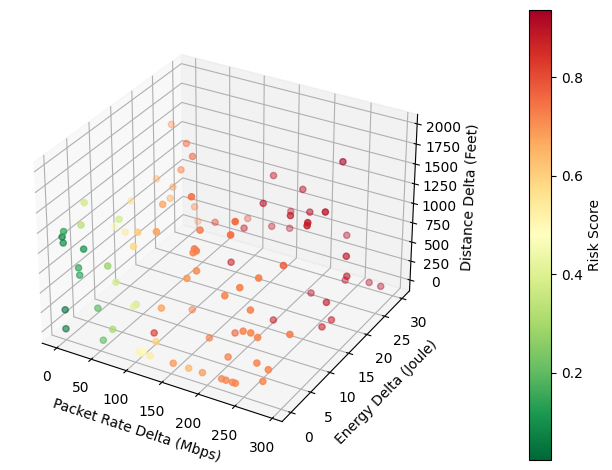

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('test_results.csv')

# Generate some sample data
input_var1 = data['packetRateDelta']
input_var2 = data['energyDelta']
input_var3 = data['distanceDelta']
outcome = data['riskScore']

# Create a scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot with colors based on 'outcome'
scatter = ax.scatter(input_var1, input_var2, input_var3, c=(outcome), cmap='RdYlGn_r')

# Set labels for the axes
ax.set_xlabel('Packet Rate Delta (Mbps)')
ax.set_ylabel('Energy Delta (Joule)')
ax.set_zlabel('Distance Delta (Feet)')

# Add color bar to show the mapping of 'outcome' values to colors
cbar = plt.colorbar(scatter, pad=0.15)  # Adjust the 'pad' value to move the colorbar
cbar.set_label('Risk Score')

# Adjust layout to make room for the colorbar
plt.tight_layout()

# Show the plot
plt.show()


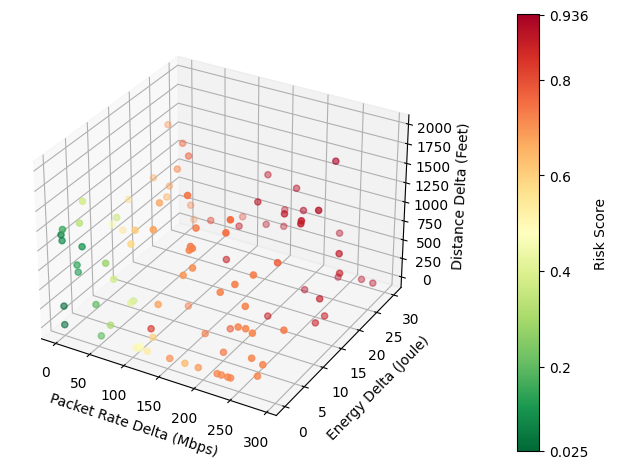

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('test_results.csv')

# Generate some sample data
input_var1 = data['packetRateDelta']
input_var2 = data['energyDelta']
input_var3 = data['distanceDelta']
outcome = data['riskScore']

# Create a scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot with colors based on 'outcome'
scatter = ax.scatter(input_var1, input_var2, input_var3, c=(outcome), cmap='RdYlGn_r')

# Set labels for the axes
ax.set_xlabel('Packet Rate Delta (Mbps)')
ax.set_ylabel('Energy Delta (Joule)')
ax.set_zlabel('Distance Delta (Feet)')

# Add color bar to show the mapping of 'outcome' values to colors
cbar = plt.colorbar(scatter, pad=0.15)  # Adjust the 'pad' value to move the colorbar

# Set the desired colorbar ticks and labels
colorbar_ticks = [0.025, 0.20, 0.40, 0.60, 0.80, 0.936]
cbar.set_ticks(colorbar_ticks)
cbar.set_ticklabels([str(tick) for tick in colorbar_ticks])

cbar.set_label('Risk Score')

# Adjust layout to make room for the colorbar
plt.tight_layout()

# Show the plot
plt.savefig('riskEstimations.pdf', dpi=300, bbox_inches='tight')

plt.show()


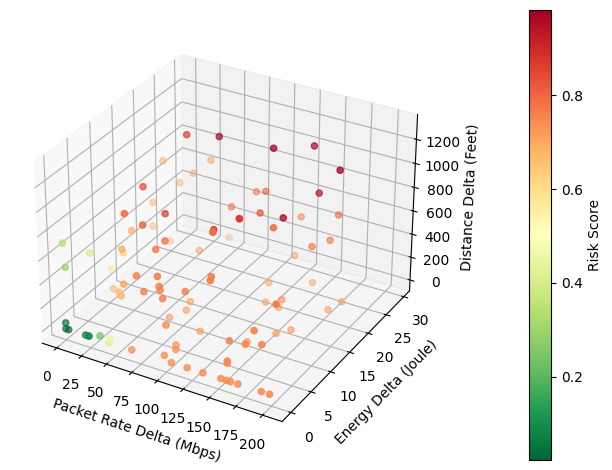

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('test_results.csv')

# Generate some sample data
input_var1 = data['packetRateDelta']
input_var2 = data['energyDelta']
input_var3 = data['distanceDelta']
outcome = data['riskScore']

# Create a scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot with colors based on 'outcome'
scatter = ax.scatter(input_var1, input_var2, input_var3, c=(outcome), cmap='RdYlGn_r')

# Set labels for the axes
ax.set_xlabel('Packet Rate Delta (Mbps)')
ax.set_ylabel('Energy Delta (Joule)')
ax.set_zlabel('Distance Delta (Feet)')

# Add color bar to show the mapping of 'outcome' values to colors
cbar = plt.colorbar(scatter, pad=0.15)  # Adjust the 'pad' value to move the colorbar
cbar.set_label('Risk Score')

# Adjust layout to make room for the colorbar
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
request = {
    "sourceDroneId": 3,
    "destDroneId": 5,
    "networkSpeed": 1000,
    "energy": 28,
    "packetRate": 328, 
    "location": [320, 2424]
}
execute_zerotrust('drone_sim_32.json', 'attack_sim_data_200.csv', 'controller_config.json', request)
file_name = 'test_results.csv'
try:
    # Try reading the existing file
    existing_data = pd.read_csv(file_name)
except FileNotFoundError:
    # If the file doesn't exist, create a new DataFrame
    existing_data = pd.DataFrame()

# Convert the new data dictionary to a DataFrame
new_data_df = pd.DataFrame([test_result])

# Append the new data to the existing DataFrame
updated_data = pd.concat([existing_data, new_data_df], ignore_index=True)

# Save the updated DataFrame to the CSV file
updated_data.to_csv(file_name, index=False)
print("Results saved to csv file.")

averageenergy: 19.917616456345538, energy_delta: 8.082383543654462
Faker prob: 0.9152542372881356
averagePacketRate: 197.3754602885369
packetRateDelta: 130.6245397114631
Flooder prob: 0.99
distAvg: 1517.5939590370824, distDelta: 927.4369201135266
capture prob: 0.4166666666666667
[{'id': 1, 'tier': 4, 'energy': 17.242280077831094, 'packet_rate': 239.38860369125345, 'location': [1177.0722321023181, -553.3113949782442]}, {'id': 2, 'tier': 4, 'energy': 19.62122651560415, 'packet_rate': 127.45774261697944, 'location': [409.1897027432133, -1011.3983745473085]}, {'id': 3, 'tier': 3, 'energy': 17.77659517275468, 'packet_rate': 171.29962368645792, 'location': [-1625.1322221867185, 1006.5753951726397]}, {'id': 4, 'tier': 4, 'energy': 19.04580114561693, 'packet_rate': 187.32101375160255, 'location': [-1088.150305814413, 1976.2102878036135]}, {'id': 5, 'tier': 3, 'energy': 21.681794131085184, 'packet_rate': 188.37333919934224, 'location': [253.06545916444475, 1427.9144925010796]}, {'id': 6, 'tier'

In [ ]:
print(test_result)

{'srcDroneId': 3, 'destDroneId': 21, 'packetRate': 195, 'energy': 22, 'distance': 2525.8790549034607, 'packetRateAvg': 197.3754602885369, 'energyAvg': 19.917616456345538, 'distanceAvg': 1517.5939590370824, 'packetRateDelta': 0, 'energyDelta': 2.082383543654462, 'distanceDelta': 1008.2850958663782, 'flooderProb': 0.01, 'fakerProb': 0.2711864406779661, 'captureProb': 0.6, 'riskScore': 0.6102512179660448, 'criticality': 1.5, 'destDroneTier': 1, 'avlCpuCycles': 22, 'computeEaser': 1, 'slaNetworkSpeed': 1200, 'networkSpeed': 900, 'ztMetric': 91.53768269490672, 'initZtGrade': 'A', 'finalZtGrade': 'deny until cooldown'}


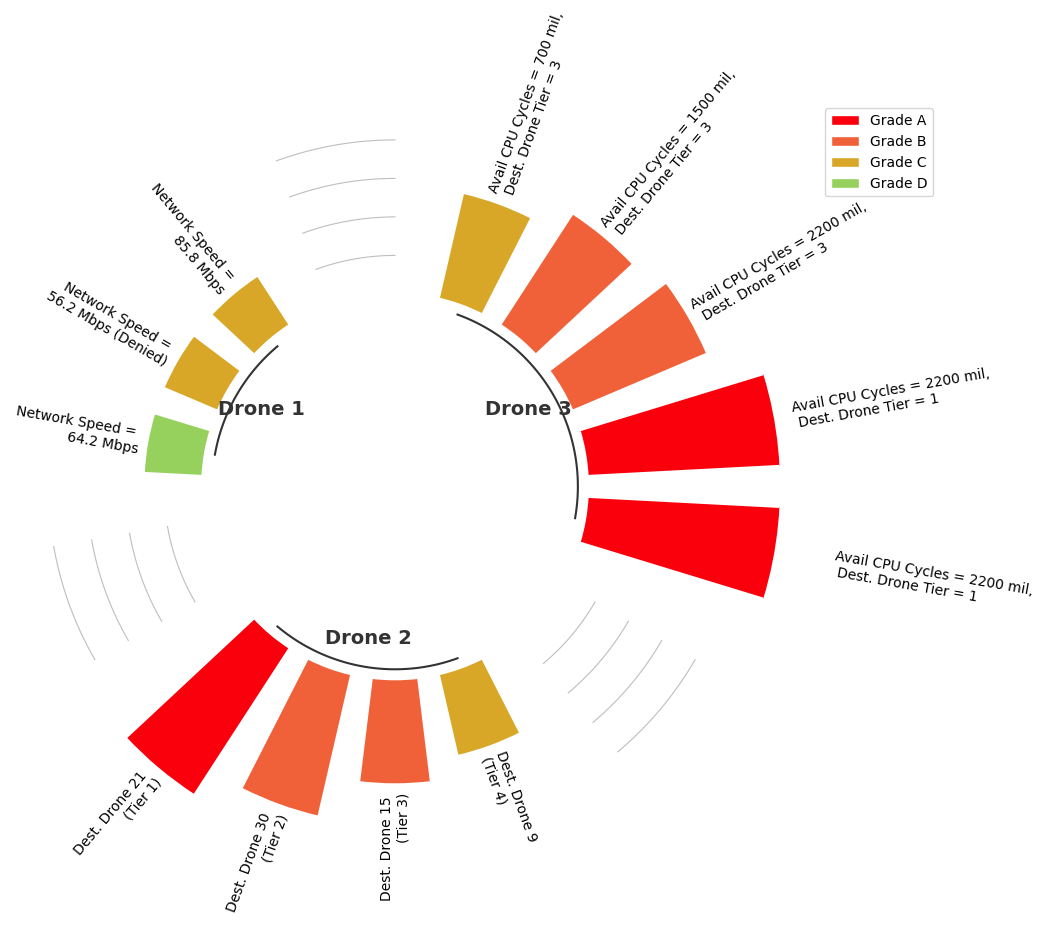

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Your DataFrame and data setup
rng = np.random.default_rng(123)
df = pd.DataFrame({
    "name": [f"item {i}" for i in range(1, 13)],
    "value": rng.integers(low=30, high=100, size=12),
    "group": ["Drone 1"] * 3 + ["Drone 2"] * 4 + ["Drone 3"] * 5
})

GROUPS_SIZE = [len(i[1]) for i in df.groupby("group")]
ANGLES_N = len(df) + 3 * len(np.unique(df["group"]))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N - 3, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)
PAD = 2

offset = 0
IDXS = []
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

# Initialize Figure and Axis
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})
ax.set_theta_offset(np.pi / 2)
ax.set_ylim(-100, 100)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

values = [
    30.8891291580071, 30.8891291580071, 30.8891291580071,
    91.53768269490672, 76.28140224575559, 54.93783604880481, 43.95026883904385,
    127.36046475731442, 106.13372063109536, 76.43746406884125, 69.41777684116023, 56.73380347232811
]

# Assign individual colors to each bar based on groups
colors = [
    '#d9a727', '#d9a727', '#95d15c', 
    '#f9000c', '#f0613a', '#f0613a', '#d9a727', 
    '#f9000c', '#f9000c', '#f0613a', '#f0613a', '#d9a727'
]

ax.bar(
    ANGLES[IDXS], values, width=WIDTH * 0.7, color=colors,
    edgecolor="white", linewidth=2
)

def get_label_rotation(angle, offset):
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else:
        alignment = "left"
    return rotation, alignment

def add_labels(angles, values, labels, offset, ax):
    padding = 4
    for angle, value, label in zip(angles, values, labels):
        rotation, alignment = get_label_rotation(angle, offset)
        ax.text(
            x=angle,
            y=value + padding,
            s=label,
            ha=alignment,
            va="center",
            rotation=rotation,
            rotation_mode="anchor"
        )

# add_labels(ANGLES[IDXS], values, df["name"].values, np.pi / 2, ax)

offset = 0
for group, size in zip(np.unique(df["group"]), GROUPS_SIZE):
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-5] * 50, color="#333333")
    ax.text(
        np.mean(x1), -20, group, color="#333333", fontsize=14,
        fontweight="bold", ha="center", va="center"
    )
    x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
    for y in [20, 40, 60, 80]:
        ax.plot(x2, [y] * 50, color="#bebebe", lw=0.8)
    offset += size + PAD

# Updated labels for the items with manual line breaks
new_labels = [
    "Network Speed = //85.8 Mbps",
    "Network Speed = //56.2 Mbps (Denied)",
    "Network Speed = //64.2 Mbps",
    "Dest. Drone 21 //(Tier 1)",
    "Dest. Drone 30 //(Tier 2)",
    "Dest. Drone 15 //(Tier 3)",
    "Dest. Drone 9 //(Tier 4)",
    "Avail CPU Cycles = 2200 mil,// Dest. Drone Tier = 1",
    "Avail CPU Cycles = 2200 mil,// Dest. Drone Tier = 1",
    "Avail CPU Cycles = 2200 mil,// Dest. Drone Tier = 3",
    "Avail CPU Cycles = 1500 mil,// Dest. Drone Tier = 3",
    "Avail CPU Cycles = 700 mil,// Dest. Drone Tier = 3"
]

# Manually format the line breaks using "\n"
formatted_labels = [label.replace('//', '\n') for label in new_labels]

# Call the add_labels function with the formatted labels
add_labels(ANGLES[IDXS], values, formatted_labels, np.pi / 2, ax)

# Adding legend
legend_elements = [
    Patch(facecolor='#f9000c', edgecolor='white', label='Grade A'),
    Patch(facecolor='#f0613a', edgecolor='white', label='Grade B'),
    Patch(facecolor='#d9a727', edgecolor='white', label='Grade C'),
    Patch(facecolor='#95d15c', edgecolor='white', label='Grade D')
]

ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))


plt.show()


In [ ]:
import numpy as np
from scipy.stats import logistic

# Define the parameters of the logistic distribution
mu = 80  # Mean of the logistic distribution
k = 25   # Scale parameter of the logistic distribution

# Generate values for the x-axis
x = np.linspace(0, 300, 500)

# Choose a specific value of x for which you want to calculate the CDF value
specific_x = 8.56432  # Replace this with the value you're interested in

# Calculate the logistic CDF
cdf_values = logistic.cdf(x, loc=mu, scale=k)

# Find the index corresponding to the specific_x in the x array
index = np.argmin(np.abs(x - specific_x))

# Get the CDF value for the specific_x
specific_cdf_value = cdf_values[index]

print(f"CDF value for x = {specific_x}: {specific_cdf_value}")

assigned = random.choices([True, False], weights=[specific_cdf_value, 1-specific_cdf_value])[0]
print(f"Choice is: {assigned}")


CDF value for x = 8.56432: 0.05399651971099635
Choice is: False


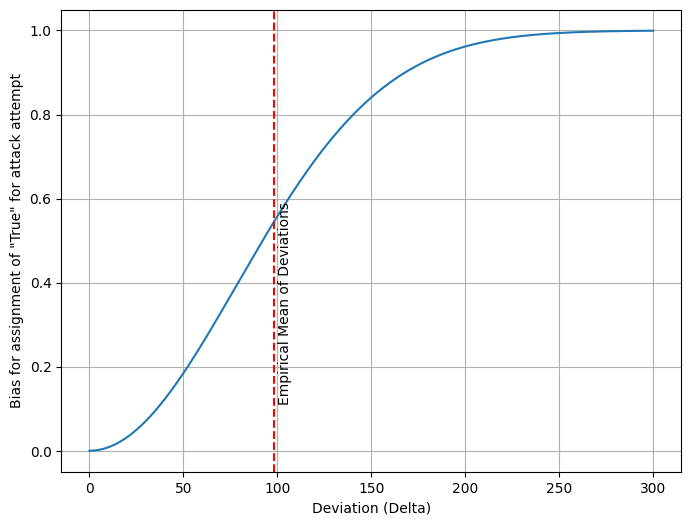

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated dynamic data with varying means
# np.random.seed(42)  # For reproducibility

# Generate x values for plotting
x = np.linspace(0, 300, 1000)

plt.figure(figsize=(8, 6))

delta_sum = 0
for _ in range(100):
    delta_sum += np.random.randint(0, 200)

mu = delta_sum/100

sigma = mu / np.sqrt(np.pi / 2)
    
# Calculate the CDF values using the formula
cdf_values = 1 - np.exp(-x**2 / (2 * sigma**2))

# Plot the CDF
plt.plot(x, cdf_values)

# plt.title('Cumulative Distribution Function with Rayleigh Distribution')
plt.xlabel('Deviation (Delta)')
plt.ylabel('Bias for assignment of "True" for attack attempt')
# plt.legend()
plt.grid()
plt.axvline(x=mu, color='red', linestyle='--', label='Mean of deviations')
plt.text(mu + 2.5, 0.35, f'Empirical Mean of Deviations', color='black', rotation=90, verticalalignment='center')
# plt.legend()
plt.show()


In [ ]:
def calculate_rayleigh_cdf(mu, x):
    sigma = mu / np.sqrt(np.pi / 2)
    cdf_value = 1 - np.exp(-x**2 / (2 * sigma**2))
    return cdf_value


In [ ]:
print(calculate_rayleigh_cdf(99.17, 75))

0.3618694848068934


C:\Users\Reddy\AppData\Local\Temp\ipykernel_1180\1427774080.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels1, rotation=60)  # Rotate x-axis labels
C:\Users\Reddy\AppData\Local\Temp\ipykernel_1180\1427774080.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels2, rotation=80)  # Rotate x-axis labels
C:\Users\Reddy\AppData\Local\Temp\ipykernel_1180\1427774080.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(labels3, rotation=60)  # Rotate x-axis labels


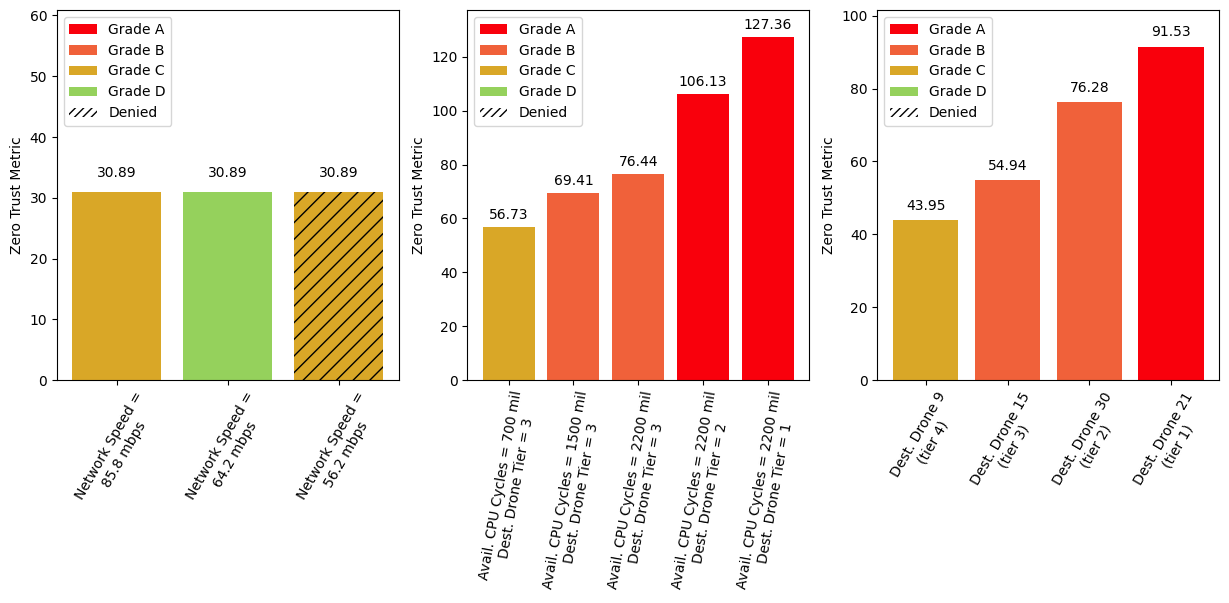

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Graph 1
labels1 = ['Network Speed =\n85.8 mbps', 'Network Speed =\n64.2 mbps', 'Network Speed =\n56.2 mbps']
values1 = [30.89, 30.89, 30.89]
colors1 = ['#d9a727', '#95d15c', '#d9a727']
hatches1 = ['', '', '//']

# Graph 2
labels2 = ['Avail. CPU Cycles = 700 mil\nDest. Drone Tier = 3', 'Avail. CPU Cycles = 1500 mil\nDest. Drone Tier = 3', 'Avail. CPU Cycles = 2200 mil\nDest. Drone Tier = 3', 'Avail. CPU Cycles = 2200 mil\nDest. Drone Tier = 2', 'Avail. CPU Cycles = 2200 mil\nDest. Drone Tier = 1']
values2 = [56.73, 69.41, 76.44, 106.13, 127.36]
colors2 = ['#d9a727', '#f0613a', '#f0613a', '#f9000c', '#f9000c']

# Graph 3
labels3 = ['Dest. Drone 9\n(tier 4)', 'Dest. Drone 15\n(tier 3)', 'Dest. Drone 30\n(tier 2)', 'Dest. Drone 21\n(tier 1)']
values3 = [43.95, 54.94, 76.28, 91.53]
colors3 = ['#d9a727', '#f0613a', '#f0613a', '#f9000c']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.bar(labels1, values1, color=colors1, hatch=hatches1)
# ax1.set_title('Scenario 1: Effect of SLA on \nZero Trust Grade')
ax1.set_xticklabels(labels1, rotation=60)  # Rotate x-axis labels
ax1.set_ylim(0, max(values1) + 30)  # Adjust y-axis limit

ax2.bar(labels2, values2, color=colors2)
# ax2.set_title('Scenario 2: Effect of Compute Easer on \nZero Trust Grade')
ax2.set_xticklabels(labels2, rotation=80)  # Rotate x-axis labels
ax2.set_ylim(0, max(values2) + 10)  # Adjust y-axis limit

ax3.bar(labels3, values3, color=colors3)
# ax3.set_title('Scenario 3: Effect of Criticality on \nZero Trust Grade')
ax3.set_xticklabels(labels3, rotation=60)  # Rotate x-axis labels
ax3.set_ylim(0, max(values3) + 10)  # Adjust y-axis limit
ax1.set_ylabel('Zero Trust Metric')
ax2.set_ylabel('Zero Trust Metric')
ax3.set_ylabel('Zero Trust Metric')


# Display numerical values on top of the bars
def add_values(ax, values):
    for i, v in enumerate(values):
        ax.text(i, v + 2, str(v), ha='center', va='bottom')

add_values(ax1, values1)
add_values(ax2, values2)
add_values(ax3, values3)

# Creating a custom legend
legend_elements = [
    Patch(facecolor='#f9000c', label='Grade A'),
    Patch(facecolor='#f0613a', label='Grade B'),
    Patch(facecolor='#d9a727', label='Grade C'),
    Patch(facecolor='#95d15c', label='Grade D'),
    Patch(facecolor='white', hatch='////', label='Denied')
]

plt.subplots_adjust(top=0.85)

ax1.legend(handles=legend_elements, loc='upper left')
ax2.legend(handles=legend_elements, loc='upper left')
ax3.legend(handles=legend_elements, loc='upper left')

plt.savefig('output.pdf', dpi=300, bbox_inches='tight')

# plt.tight_layout()
plt.show()


In [ ]:

# throughput = network speed
# jitter = content size / speed
def get_comm_metrics(content_size, network_speed):
    res = {'content_size': content_size, "network_speed": network_speed}
    res['actual_time'] = content_size/network_speed
    for grade in ['E (Role-based Access Control)', 'D (+Intrusion Detection)', 'C (+Multi-factor Authentication)', 'B (+Attribute-based Access Control)', 'A (+Behavioral Analysis)']:
        throughput = network_speed * random.uniform(0.85, 0.95)
        if grade == 'E (Role-based Access Control)':
            res[grade] = throughput
        throughput = throughput * random.uniform(0.72, 0.80)
        if grade == 'D (+Intrusion Detection)':
            res[grade] = throughput
        throughput = throughput - random.uniform(68, 84)
        # * random.uniform(0.77, 0.83)
        if grade == 'C (+Multi-factor Authentication)':
            res[grade] = throughput
        throughput = throughput - random.uniform(57, 72)
        if grade == 'B (+Attribute-based Access Control)':
            res[grade] = throughput
        throughput = throughput * random.uniform(0.45, 0.74)
        if grade == 'A (+Behavioral Analysis)':
            res[grade] = throughput
    return res

In [ ]:
network_speed = 1224
content_sizes = range(100, 16001, 157)  # Adjust the step size as needed

metrics_dict = {}

for content_size in content_sizes:
    result = get_comm_metrics(content_size, network_speed)
    metrics_dict[content_size] = result

print(metrics_dict)


{100: {'content_size': 100, 'network_speed': 1224, 'actual_time': 0.08169934640522876, 'E (Role-based Access Control)': 1059.0461980649673, 'D (+Intrusion Detection)': 845.489695429613, 'C (+Multi-factor Authentication)': 841.224442347432, 'B (+Attribute-based Access Control)': 626.2281054847668, 'A (+Behavioral Analysis)': 391.16858620103204}, 257: {'content_size': 257, 'network_speed': 1224, 'actual_time': 0.2099673202614379, 'E (Role-based Access Control)': 1076.3514737114203, 'D (+Intrusion Detection)': 889.3905066883608, 'C (+Multi-factor Authentication)': 691.3293000051492, 'B (+Attribute-based Access Control)': 739.8793689418694, 'A (+Behavioral Analysis)': 376.4033229455641}, 414: {'content_size': 414, 'network_speed': 1224, 'actual_time': 0.3382352941176471, 'E (Role-based Access Control)': 1156.9842848250323, 'D (+Intrusion Detection)': 823.7993213788757, 'C (+Multi-factor Authentication)': 784.6213001625761, 'B (+Attribute-based Access Control)': 760.5957494235513, 'A (+Beha

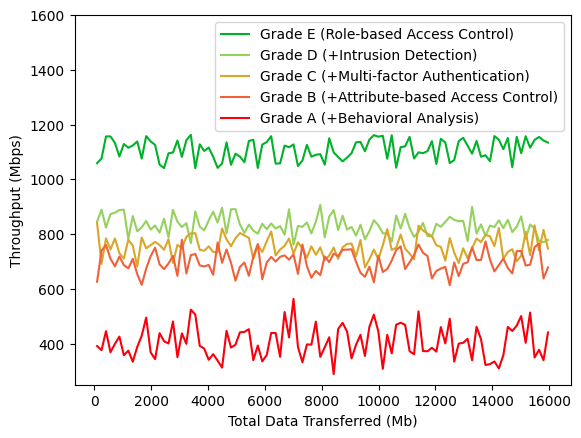

In [ ]:
data = metrics_dict

colors = {
    'E (Role-based Access Control)': '#00b12a',
    'D (+Intrusion Detection)': '#95d15c',
    'C (+Multi-factor Authentication)': '#d9a727',
    'B (+Attribute-based Access Control)': '#f0613a',
    'A (+Behavioral Analysis)': '#f9000c'
}

plt.figure()

x_values = list(data.keys())  # Get all the key values

# Iterate through each category and plot the data for all keys
for category, color in colors.items():
    y_values = [values[category] for values in data.values()]
    plt.plot(x_values, y_values, label=f'Grade {category}', color=color)

plt.xlabel('Total Data Transferred (Mb)')
plt.ylabel('Throughput (Mbps)')
plt.ylim(250, 1600)
# plt.title('Throughput Comparison')
plt.legend()
plt.savefig('thru_analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()

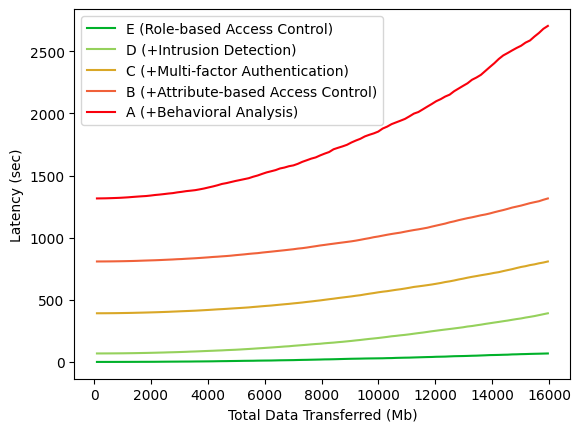

In [ ]:
data = metrics_dict

colors = {
    'E (Role-based Access Control)': '#00b12a',
    'D (+Intrusion Detection)': '#95d15c',
    'C (+Multi-factor Authentication)': '#d9a727',
    'B (+Attribute-based Access Control)': '#f0613a',
    'A (+Behavioral Analysis)': '#f9000c'
}

plt.figure()

x_values = list(data.keys())  # Get all the key values
latency = 0
# Iterate through each category and plot the data for all keys
latencies = {}
for category, color in colors.items():
    y_values = []
    for size, thru in data.items():
        latency += size/thru[category] - thru['actual_time']
        y_values.append(latency)
    # y_values = [values[category] for values in data.values()]
    latencies[category] = latency
    plt.plot(x_values, y_values, label=category, color=color)

plt.xlabel('Total Data Transferred (Mb)')
plt.ylabel('Latency (sec)')
# plt.title('Latency Comparison')
plt.legend()
plt.savefig('latency_analysis.pdf', dpi=300, bbox_inches='tight')

plt.show()

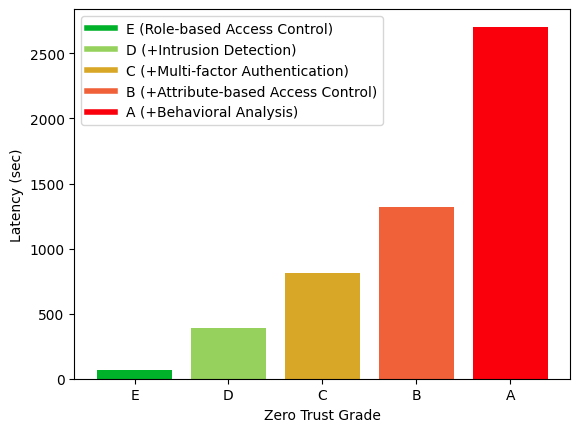

In [ ]:
import matplotlib.pyplot as plt

data = metrics_dict

colors = {
    'E (Role-based Access Control)': '#00b12a',
    'D (+Intrusion Detection)': '#95d15c',
    'C (+Multi-factor Authentication)': '#d9a727',
    'B (+Attribute-based Access Control)': '#f0613a',
    'A (+Behavioral Analysis)': '#f9000c'
}

plt.figure()

x_values = [category[0] for category in latencies.keys()]  # Use only the first character from keys
y_values = list(latencies.values())  # Use latencies dictionary values

# Create a bar plot with corresponding colors
bars = plt.bar(x_values, y_values, color=[colors[category] for category in latencies.keys()])

plt.xlabel('Zero Trust Grade')
plt.ylabel('Latency (sec)')
# plt.title('Latency Analysis')
plt.xticks(rotation=0)  # No rotation for x-axis labels

# Add legend with custom legend handles based on colors
legend_handles = [plt.Line2D([0], [0], color=color, lw=4, label=category) for category, color in colors.items()]
plt.legend(handles=legend_handles)

# Save the plot to a file
plt.savefig('latency_analysis.pdf', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
print(y_values[-1])

440.8652310709602


In [6]:
import requests
from bs4 import BeautifulSoup

def get_title_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        title_tag = soup.find('title')
        if title_tag:
            title = title_tag.text.strip()
        else:
            title = "No Title"
        return title
    except requests.RequestException as e:
        return str(e)
    except AttributeError:
        return "Error"

def generate_titles_with_urls(url_list):
    result = []
    for url in url_list:
        title = get_title_from_url(url)
        result.append(f"{url} - {title}")
    return result

# Example list of URLs
urls = [
    "https://www.mdpi.com/2078-2489/14/2/129",
    "https://ieeexplore.ieee.org/abstract/document/9634878",
    "https://ieeexplore.ieee.org/abstract/document/9357330",
    "https://ieeexplore.ieee.org/abstract/document/10074295",
    "https://myhr.umsystem.edu"
]

titles_with_urls = generate_titles_with_urls(urls)
for item in titles_with_urls:
    print(item)


https://www.mdpi.com/2078-2489/14/2/129 - Information | Free Full-Text | A Blockchain-Inspired Attribute-Based Zero-Trust Access Control Model for IoT
https://ieeexplore.ieee.org/abstract/document/9634878 - 418 Client Error: Unknown for url: https://ieeexplore.ieee.org/abstract/document/9634878
https://ieeexplore.ieee.org/abstract/document/9357330 - 418 Client Error: Unknown for url: https://ieeexplore.ieee.org/abstract/document/9357330
https://ieeexplore.ieee.org/abstract/document/10074295 - 418 Client Error: Unknown for url: https://ieeexplore.ieee.org/abstract/document/10074295
https://myhr.umsystem.edu - Sign in to your account
